# DEEP METRIC LEARNING ON MNIST DATASET

## DOWNLOAD THE DATASET AND SPLIT INTO TRAIN (VALIDATION) AND TEST


In [1]:
import os
os.chdir('..')
import networks, losses,train, datasets
import torch
from torchvision.transforms import ToTensor, transforms
from torchsummary import summary
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pandas as pd
import seaborn as sn

/Users/test1/miniconda3/envs/computervision/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# select the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.get_device_name()

print('Working on ', device)

x_train, y_train, x_test, y_test = datasets.download_MNIST()
labels = np.unique(y_train)

train_data, test_data = datasets.to_torch_data(x_train, y_train, x_test, y_test)

# split again to obtain validation dataset

lengths = (42500, 7500)

train_data, valid_data = torch.utils.data.random_split(train_data, lengths)
train_data = datasets.ContrastiveDataset(train_data,
                 train=True,
                 transform=transforms.ToTensor())

valid_data = datasets.ContrastiveDataset(valid_data,
                 train=False,
                 transform=transforms.ToTensor())

test_data = datasets.ContrastiveDataset(test_data,
                 train=False,
                 transform=transforms.ToTensor())



# print(test_data[0])
# by the way pytorch loads the images, they are already normalized 
# we don't divide by 255

print('Length train data', len(train_data))
print('Length test data', len(test_data)) 

# check if the classes are balanced in the training dataset
# and create a vector of the number of samples in the test set for each class

labels = np.unique(train_data.labels)
print('The different digits classes are', labels)
x = 0
for i in labels:
    y = len(train_data.labels[train_data.labels==i])
    x += y
    print('Class', i ,'has',y ,'elements')
print(x)
# more or less are balanced !

Working on  cpu
Length train data 42500
Length test data 10000
The different digits classes are [0 1 2 3 4 5 6 7 8 9]
Class 0 has 4170 elements
Class 1 has 4832 elements
Class 2 has 4245 elements
Class 3 has 4358 elements
Class 4 has 4106 elements
Class 5 has 3820 elements
Class 6 has 4204 elements
Class 7 has 4378 elements
Class 8 has 4113 elements
Class 9 has 4274 elements
42500


## CONTRASTIVE LOSS

### TRAINING USING A DENSE LINEAR NEURAL NETWORK

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
            Linear-6                    [-1, 2]           1,026
           Sigmoid-7                    [-1, 2]               0
Total params: 1,329,666
Trainable params: 1,329,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 5.07
Estimated Total Size (MB): 5.10
----------------------------------------------------------------
None


Epoch: 1/5 - Loss: 0.0173


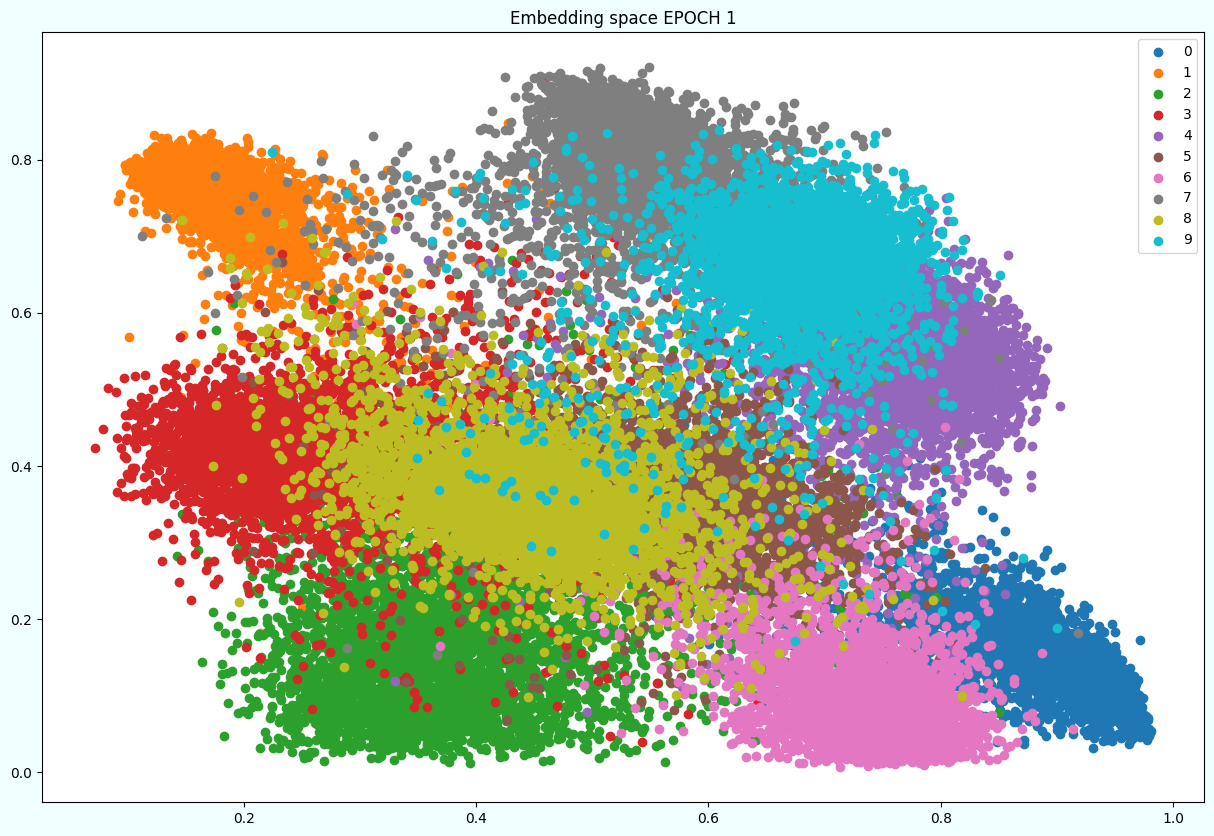

Shape of the data in the learned metric space: (42500, 2)


Epoch: 2/5 - Loss: 0.0103
Shape of the data in the learned metric space: (42500, 2)


Epoch: 3/5 - Loss: 0.0084
Shape of the data in the learned metric space: (42500, 2)


Epoch: 4/5 - Loss: 0.0073
Shape of the data in the learned metric space: (42500, 2)


Epoch: 5/5 - Loss: 0.0064


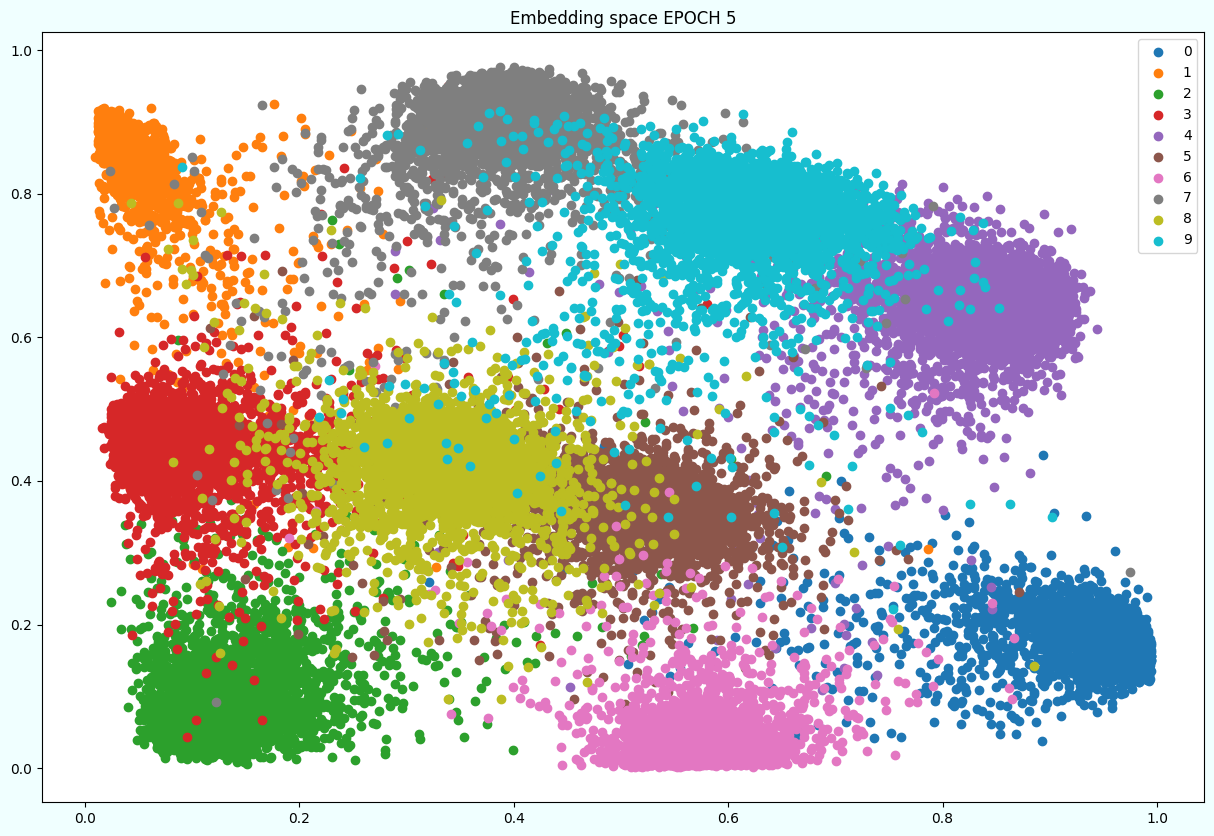

Shape of the data in the learned metric space: (42500, 2)


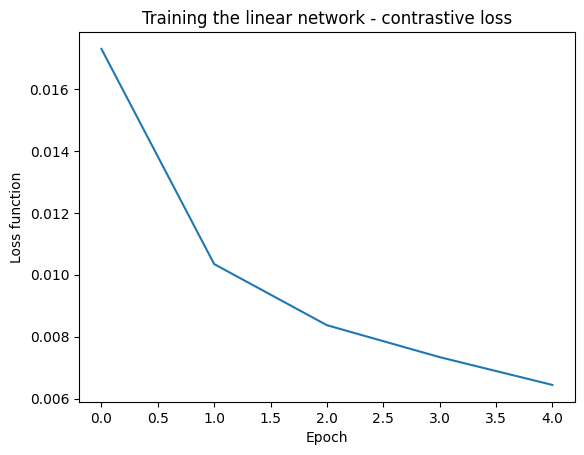

The shape of the embedded train dataset is (42500, 2)
(10000, 2)


ValueError: Found input variables with inconsistent numbers of samples: [42500, 50000]

In [13]:
### TRAIN NEURAL NETWORK ON MINST DATASET

batch_size = 64
train_dataloader, test_dataloader = datasets.get_data_loader(train_data, test_data, batch_size)

lr = 0.0001

margin = 0.5
epochs = 5

# TRAINING:
model = networks.LinearNetwork(emb_dim=2).to(device)
print(summary(model, (28,28)))

## ADAM optimizer 'Adaptive Moment Estimation' extends stochastic gradient descend
# set the parameters as in matlab tutorial
# Set the gradient decay factor to 0.9 and the squared gradient decay factor to 0.99 (default values in pytorch adam)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Exponential learning rate scheduler
# Decay LR by a factor of 0.1 every 2 epochs (not used)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

epochs_toplot = [0,4]
loss_per_epoch_vector, train_results = train.fit_contrastive(
  train_dataloader, train_data, model, epochs, optimizer, labels, margin=margin, epochs_toplot=epochs_toplot)
# torch.save(model, 'contrastive_linear_margin=0.5.pth')

### PLOT THE LEARNING ERROR

history_epoch=[i for i in range(epochs)]
# Plot loss
plt.title('Training the linear network - contrastive loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.plot(history_epoch, loss_per_epoch_vector)
plt.show()


#### EVALUATION
# model_linear = torch.load('contrastive_linear_margin=0.5.pth')

print('The shape of the embedded train dataset is', train_results.shape)

test_data.set_train(False)
test_results = []
model.eval()
# # model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time.
with torch.no_grad(): # the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation
    for i in test_data.index:
        image = test_data[i]
        test_results.append(model(image.to(device)).cpu().numpy()) # convert the output of the network into numpy array

test_results = np.concatenate(test_results) # Join a sequence of arrays along an existing axis
print(test_results.shape) # emb_dim coordinates for all the 10000 observations

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(train_results, y_train)
y_pred = neigh.predict(test_results)
y_test = test_data.labels
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

N_class_test=[]
x = 0
for i in labels:
    n_class = len(y_test[y_test==i])
    N_class_test.append(n_class)
    x += n_class
print(N_class_test)
print(x)

cf_matrix = metrics.confusion_matrix(y_test, y_pred)

# modify the cf_matrix in order to have the percentage of classified for each class
# with this approach each element in the diagonal is the accuracy per class

C = len(labels)
x = np.zeros((C,C))
for i in range(C):
  row = cf_matrix[i,:]/N_class_test[i]
  x[i,:] = row

df_cm = pd.DataFrame(x, index = [i for i in labels], columns = [i for i in labels])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

Accuracy: 0.9359
[991, 1064, 990, 1030, 983, 915, 967, 1090, 1009, 961]
10000


<AxesSubplot: >

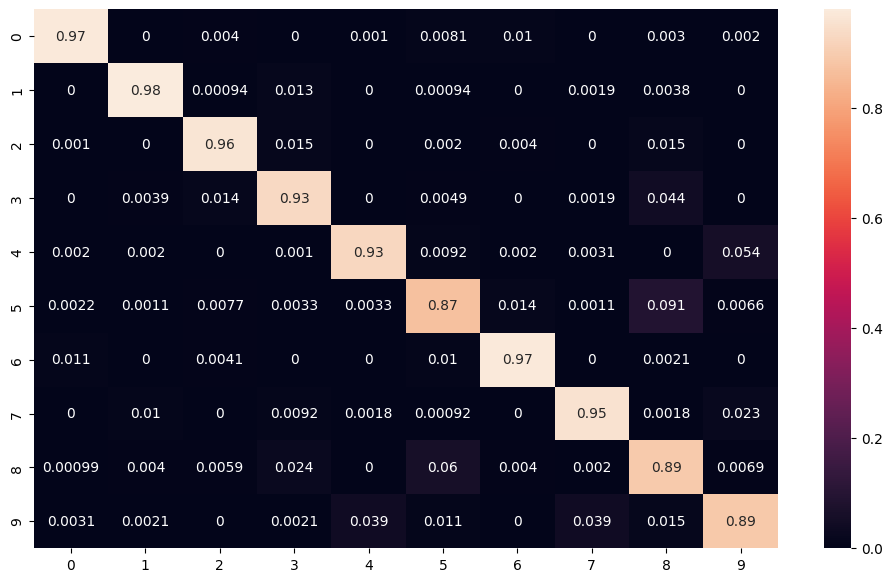

In [14]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(train_results, train_data.labels)
y_pred = neigh.predict(test_results)
y_test = test_data.labels
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

N_class_test=[]
x = 0
for i in labels:
    n_class = len(y_test[y_test==i])
    N_class_test.append(n_class)
    x += n_class
print(N_class_test)
print(x)

cf_matrix = metrics.confusion_matrix(y_test, y_pred)
# modify the cf_matrix in order to have the percentage of classified for each class
# with this approach each element in the diagonal is the accuracy per class

C = len(labels)
x = np.zeros((C,C))
for i in range(C):
  row = cf_matrix[i,:]/N_class_test[i]
  x[i,:] = row

df_cm = pd.DataFrame(x, index = [i for i in labels], columns = [i for i in labels])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

### TRAINING USING A CONVOLUTIONAL NEURAL NETWORK

In [8]:
batch_size = 64
train_dataloader, test_dataloader = datasets.get_data_loader(train_data, test_data, batch_size)

lr = 0.0001
margin = 0.3
epochs = 5
emb_dim = 4
# TRAINING CNN:
model_cnn = networks.CNN(emb_dim).to(device)
print(summary(model_cnn, (1,28,28)))

## ADAM optimizer 'Adaptive Moment Estimation' extends stochastic gradient descend
# set the parameters as in matlab tutorial
# Set the gradient decay factor to 0.9 and the squared gradient decay factor to 0.99 (default values in pytorch adam)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=lr, betas=(0.9, 0.999))

# Exponential learning rate scheduler
# Decay LR by a factor of 0.1 every 2 epochs (not used)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 24, 24]             390
              ReLU-2           [-1, 15, 24, 24]               0
         MaxPool2d-3             [-1, 15, 8, 8]               0
            Conv2d-4             [-1, 30, 1, 1]          28,830
              ReLU-5             [-1, 30, 1, 1]               0
            Linear-6                    [-1, 4]             124
           Sigmoid-7                    [-1, 4]               0
Total params: 29,344
Trainable params: 29,344
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.11
Estimated Total Size (MB): 0.25
----------------------------------------------------------------
None


Epoch: 1/5 - Loss: 0.0074
Shape of the data in the learned metric space: (42500, 4)


Epoch: 2/5 - Loss: 0.0047
Shape of the data in the learned metric space: (42500, 4)


Epoch: 3/5 - Loss: 0.0039
Shape of the data in the learned metric space: (42500, 4)


Epoch: 4/5 - Loss: 0.0035
Shape of the data in the learned metric space: (42500, 4)


Epoch: 5/5 - Loss: 0.0031
Shape of the data in the learned metric space: (42500, 4)
(42500, 4)


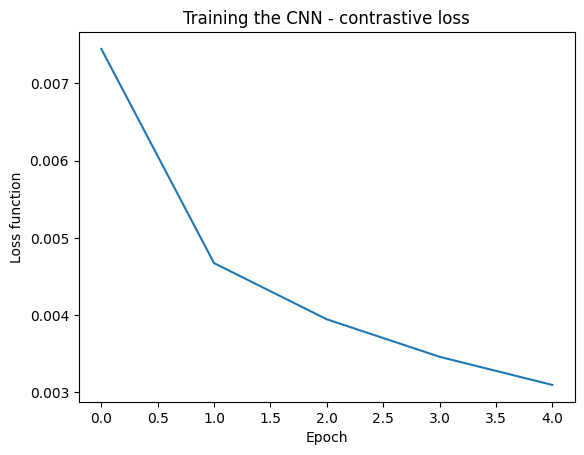

In [10]:
epochs_toplot = None
loss_per_epoch_vector, train_results = train.fit_contrastive(
    train_dataloader, train_data, model_cnn, epochs, optimizer, labels, margin=margin)
# torch.save(model, 'contrastive_cnn_margin=0.01.pth')

print(train_results.shape) # emb_dim coordinates for all the 50000 observations

### PLOT THE LEARNING ERROR

history_epoch=[i for i in range(epochs)]
# Plot loss
plt.title('Training the CNN - contrastive loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.plot(history_epoch, loss_per_epoch_vector)
plt.show()

(10000, 4)
Accuracy: 0.9566
The number of test images in the different classes is [991, 1064, 990, 1030, 983, 915, 967, 1090, 1009, 961]
10000


<AxesSubplot: >

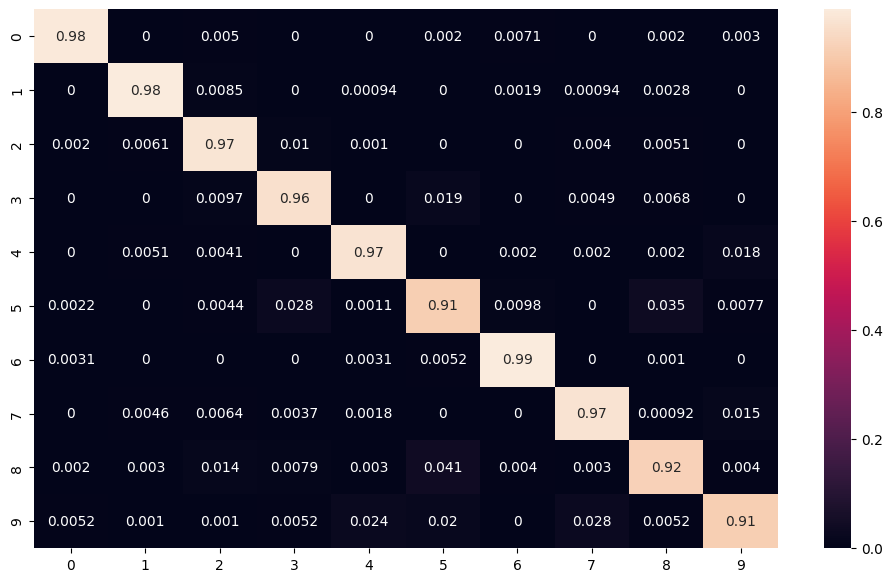

In [11]:
#### EVALUATION
# model_cnn = torch.load('contrastive_cnn_margin=0.01.pth')

test_data.set_train(False)
test_results = []
model_cnn.eval()
# # model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time.
with torch.no_grad(): # the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation
    for i in test_data.index:
        image = test_data[i]
        test_results.append(model_cnn(image.to(device)).cpu().numpy()) # convert the output of the network into numpy array

test_results = np.concatenate(test_results) # Join a sequence of arrays along an existing axis
print(test_results.shape) # 2 coordinates for all the 10000 observations

# use a 10-NN classifier to classify new images
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(train_results, train_data.labels)
y_pred = neigh.predict(test_results)
y_test = test_data.labels
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# CONFUSION MATRIX with accuracy per class

N_class_test=[]
x = 0
for i in labels:
    n_class = len(y_test[y_test==i])
    N_class_test.append(n_class)
    x += n_class
print('The number of test images in the different classes is', N_class_test)
print(x)

cf_matrix = metrics.confusion_matrix(y_test, y_pred)

# modify the cf_matrix in order to have the percentage of classified for each class
# with this approach each element in the diagonal is the accuracy per class

C = len(labels)
x = np.zeros((C,C))
for i in range(C):
  row = cf_matrix[i,:]/N_class_test[i]
  x[i,:] = row

df_cm = pd.DataFrame(x, index = [i for i in labels], columns = [i for i in labels])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
# plt.savefig('cf_matrix_contrastive_cnn.png')

### ROLE OF THE MARGIN

In [ ]:
batch_size = 64
train_dataloader, test_dataloader = datasets.get_data_loader(train_data, test_data, batch_size)

lr = 0.0001

# change the number of epochs
epochs = 1
epochs_toplot = [0]

# for each value of margin, we associate the accuracy of the validation classification
# we want to choose the best margin for the epochs selected
# the idea is that for a small number of epoch a big margin is better
accuracy_validation = []
models = [] # create also a list of models in order to save the best one


for margin in [0.05, 0.1, 0.3, 0.5, 1]: # for margin=1.5 we are sure the loss is never 0
  print('Margin is', margin)
  model = networks.CNN().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
  loss_per_epoch_vector, valid_accuracy = train.fit_contrastive_validation(train_dataloader, train_data, valid_data, 
                                                                       model, epochs, epochs_toplot, optimizer, labels, 
                                                                       scheduler=None, margin=margin)
  print('The accuracy on the validation set is',valid_accuracy)  
  accuracy_validation.append(valid_accuracy)
  models.append(model)

  ### PLOT THE LEARNING ERROR
  print('Learning error plot for margin=', margin)
  history_epoch=[i for i in range(epochs)]
  plt.title('Training the CNN - contrastive loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss function')
  plt.plot(history_epoch, loss_per_epoch_vector)
  plt.show()

epochs = 5
epochs_toplot = [4]

# for each value of margin, we associate the accuracy of the validation classification
# we want to choose the best margin for the epochs selected
# the idea is that for a small number of epoch a big margin is better
accuracy_validation = []
models = [] # create also a list of models in order to save the best one


for margin in [0.05, 0.1, 0.3, 0.5, 1]: # for margin=1.5 we are sure the loss is never 0
  print('Margin is', margin)
  model = networks.CNN().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
  loss_per_epoch_vector, valid_accuracy = train.fit_contrastive_validation(train_dataloader, train_data, valid_data, 
                                                                       model, epochs, epochs_toplot, optimizer, labels, 
                                                                       scheduler=None, margin=margin)
  print('The accuracy on the validation set is',valid_accuracy)  
  accuracy_validation.append(valid_accuracy)
  models.append(model)

  ### PLOT THE LEARNING ERROR
  print('Learning error plot for margin=', margin)
  history_epoch=[i for i in range(epochs)]
  plt.title('Training the CNN - triplet loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss function')
  plt.plot(history_epoch, loss_per_epoch_vector)
  plt.show()


## TRIPLET LOSS

### COMPARISON WITH CONTRASTIVE LOSS USING A CNN

Accuracy: 0.9736
The number of test images in the different classes is [991, 1064, 990, 1030, 983, 915, 967, 1090, 1009, 961]
10000


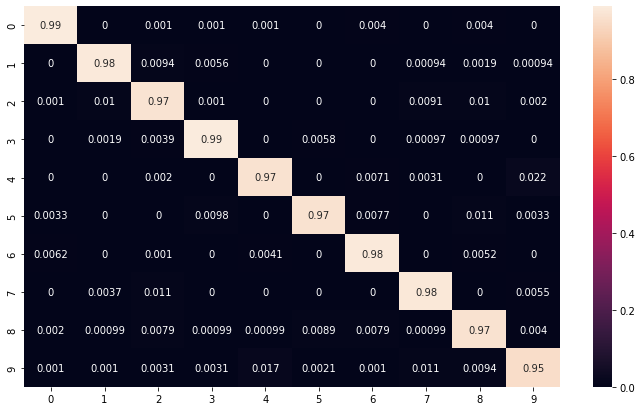

In [ ]:
batch_size = 64
train_dataloader, test_dataloader = datasets.get_data_loader(train_data, test_data, batch_size)

lr = 0.0001
margin = 0.3
epochs = 5

# TRAINING CNN:
model = networks.CNN().to(device)
print(summary(model, (1,28,28)))

## ADAM optimizer 'Adaptive Moment Estimation' extends stochastic gradient descend
# set the parameters as in matlab tutorial
# Set the gradient decay factor to 0.9 and the squared gradient decay factor to 0.99 (default values in pytorch adam)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Exponential learning rate scheduler
# Decay LR by a factor of 0.1 every 2 epochs (not used)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

epochs_toplot = [0,4,14,21,29]
loss_per_epoch_vector, train_results = train.fit_triplet(train_dataloader, train_data, model, epochs, epochs_toplot, optimizer, labels, scheduler=exp_lr_scheduler, margin=margin)
torch.save(model, 'triplet_cnn_margin=0.15.pth')

print(train_results.shape) # 2 coordinates for all the 50000 observations

### PLOT THE LEARNING ERROR

history_epoch=[i for i in range(epochs)]
# Plot loss
plt.title('Training the CNN - triplet loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.plot(history_epoch, loss_per_epoch_vector)
plt.show()


#### EVALUATION
model_cnn = torch.load('triplet_cnn_margin=0.15.pth')


test_data.set_train(False)
test_results = []
model_cnn.eval()
# # model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time.
with torch.no_grad(): # the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation
    for i in test_data.index:
        image = test_data[i]
        test_results.append(model_cnn(image.to(device)).cpu().numpy()) # convert the output of the network into numpy array

test_results = np.concatenate(test_results) # Join a sequence of arrays along an existing axis
print(test_results.shape) # 2 coordinates for all the 10000 observations

# use a 10-NN classifier to classify new images
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(train_results, train_data.labels)
y_pred = neigh.predict(test_results)
y_test = test_data.labels
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# CONFUSION MATRIX with accuracy per class

N_class_test=[]
x = 0
for i in labels:
    n_class = len(y_test[y_test==i])
    N_class_test.append(n_class)
    x += n_class
print('The number of test images in the different classes is', N_class_test)
print(x)

import pandas as pd
import seaborn as sn
cf_matrix = metrics.confusion_matrix(y_test, y_pred)

# modify the cf_matrix in order to have the percentage of classified for each class
# with this approach each element in the diagonal is the accuracy per class

C = len(labels)
x = np.zeros((C,C))
for i in range(C):
  row = cf_matrix[i,:]/N_class_test[i]
  x[i,:] = row

df_cm = pd.DataFrame(x, index = [i for i in labels], columns = [i for i in labels])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True) 

### EXCLUDING A CLASS FROM THE TRAINING SET

In [ ]:
x_train, y_train, x_test, y_test = datasets.download_MNIST()


# zero class is almost 10 percent of the data
x_train_zero = x_train[y_train != 0]
y_train_zero = y_train[y_train != 0]

train_data, test_data = datasets.to_torch_data(x_train_zero, y_train_zero, x_test, y_test)



train_data = datasets.TripletDataset(train_data,
                 train=True,
                 transform=transforms.ToTensor())

test_data = datasets.TripletDataset(test_data,
                 train=False,
                 transform=transforms.ToTensor())

labels = np.unique(train_data.labels)
print(f'Labels are:{labels}')

batch_size = 64
train_dataloader, test_dataloader = datasets.get_data_loader(train_data, test_data, batch_size)

lr = 0.0001
margin = 0.1
epochs = 10

# TRAINING CNN:
model = networks.CNN().to(device)

## ADAM optimizer 'Adaptive Moment Estimation' extends stochastic gradient descend
# set the parameters as in matlab tutorial
# Set the gradient decay factor to 0.9 and the squared gradient decay factor to 0.99 (default values in pytorch adam)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Exponential learning rate scheduler
# Decay LR by a factor of 0.1 every 2 epochs (not used)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

epochs_toplot = [9]
loss_per_epoch_vector, train_results = train.fit_triplet(train_dataloader, train_data, model, epochs, epochs_toplot, optimizer, labels, scheduler=None, margin=margin)
torch.save(model, 'triplet_cnn_margin=0.1_noclasszero.pth')

print(train_results.shape) # 2 coordinates for all the 50000 observations

In [ ]:
#### EVALUATION
model_cnn = torch.load('contrastive_cnn_margin=0.15_noclasszero.pth')

test_data.set_train(False)
test_results = []
model_cnn.eval()
# # model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time.
with torch.no_grad(): # the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation
    for i in test_data.index:
        image = test_data[i]
        test_results.append(model_cnn(image.to(device)).cpu().numpy()) # convert the output of the network into numpy array

test_results = np.concatenate(test_results) # Join a sequence of arrays along an existing axis
print(test_results.shape) # 2 coordinates for all the 10000 observations

# now I plot the test results in the embedding space
plt.figure(figsize=(15, 10), facecolor="azure")
plt.title('Embedding space test set (no class 0)')
labels = np.unique(y_test)
print(labels)
for label in labels:
  coord = test_results[y_test == label]  # select the indexes for images with the same label
  plt.scatter(coord[:, 0], coord[:, 1], label=label)  # scatter plot of the different classes in the embedding space
plt.legend()
plt.show()

### DEALING WITH CLASS IMBALANCE



Accuracy: 0.9202
The number of test images in the different classes is [991, 1064, 990, 1030, 983, 915, 967, 1090, 1009, 961]
10000


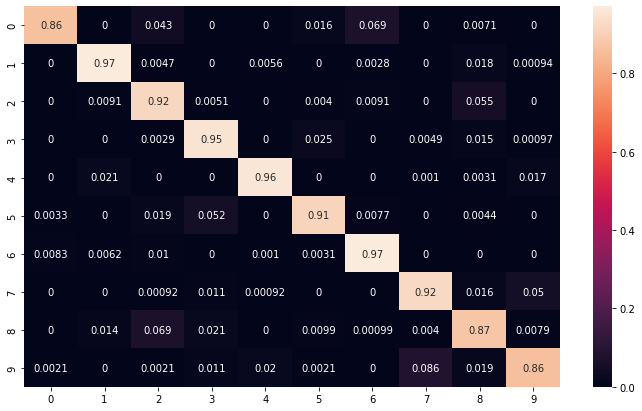

In [ ]:
import networks, losses,train, datasets
import torch
from torchvision.transforms import ToTensor, transforms
from torchsummary import summary
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler 

# select the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.get_device_name()

x_train, y_train, x_test, y_test = datasets.download_MNIST()

zero_class_train = x_train[y_train==0]
zero_class_labels = y_train[y_train==0]
print(f'number of images of digit 0 is {len(zero_class_train)}')

# insert only 1000 images in the training set

print(zero_class_train[0:1000].shape)
x_train_imbalanced = np.concatenate((x_train[y_train!=0], zero_class_train[0:1000]))
y_train_imbalanced = np.concatenate((y_train[y_train!=0], zero_class_labels[0:1000]))
print(y_train_imbalanced.shape)
print(x_train_imbalanced.shape)

train_data, test_data = datasets.to_torch_data(x_train_imbalanced, y_train_imbalanced, x_test, y_test)


train_data = datasets.UniformTripletDataset(train_data,
                 train=True,
                 transform=transforms.ToTensor())

test_data = datasets.UniformTripletDataset(test_data,
                 train=False,
                 transform=transforms.ToTensor())

labels = np.unique(train_data.labels)

batch_size = 64
train_dataloader, test_dataloader = datasets.get_data_loader(train_data, test_data, batch_size)

lr = 0.0001
margin = 0.1
epochs = 10

# TRAINING CNN:
model = networks.CNN().to(device)

## ADAM optimizer 'Adaptive Moment Estimation' extends stochastic gradient descend
# set the parameters as in matlab tutorial
# Set the gradient decay factor to 0.9 and the squared gradient decay factor to 0.99 (default values in pytorch adam)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))


epochs_toplot = [0,9]
loss_per_epoch_vector, train_results = train.fit_triplet(train_dataloader, train_data, model, epochs, epochs_toplot, optimizer, labels, scheduler=None, margin=margin)
torch.save(model, 'triplet_cnn_margin=0.1_imbalanced.pth')

print(train_results.shape) # 2 coordinates for all the 50000 observations

### PLOT THE LEARNING ERROR

history_epoch=[i for i in range(epochs)]
# Plot loss
plt.title('Training the CNN - trplet loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.plot(history_epoch, loss_per_epoch_vector)
plt.show()


#### EVALUATION
model_cnn = torch.load('triplet_cnn_margin=0.1_imbalanced.pth')

test_data.set_train(False)
test_results = []
model_cnn.eval()
# # model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time.
with torch.no_grad(): # the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation
    for i in test_data.index:
        image = test_data[i]
        test_results.append(model_cnn(image.to(device)).cpu().numpy()) # convert the output of the network into numpy array

test_results = np.concatenate(test_results) # Join a sequence of arrays along an existing axis
print(test_results.shape) # 2 coordinates for all the 10000 observations

# use a 10-NN classifier to classify new images
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(train_results, y_train_imbalanced)
y_pred = neigh.predict(test_results)
y_test = test_data.labels
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# CONFUSION MATRIX with accuracy per class

N_class_test=[]
x = 0
for i in labels:
    n_class = len(y_test[y_test==i])
    N_class_test.append(n_class)
    x += n_class
print('The number of test images in the different classes is', N_class_test)
print(x)

import pandas as pd
import seaborn as sn
cf_matrix = metrics.confusion_matrix(y_test, y_pred)

# modify the cf_matrix in order to have the percentage of classified for each class
# with this approach each element in the diagonal is the accuracy per class

C = len(labels)
x = np.zeros((C,C))
for i in range(C):
  row = cf_matrix[i,:]/N_class_test[i]
  x[i,:] = row

df_cm = pd.DataFrame(x, index = [i for i in labels], columns = [i for i in labels])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)